In [3]:
import pandas as pd


# Load the datasets
death_rate = pd.read_csv("/content/death-rate-from-air-pollution-per-100000.csv")
absolute_deaths = pd.read_csv("/content/absolute-number-of-deaths-from-ambient-particulate-air-pollution.csv")


# Rename columns for clarity
death_rate = death_rate.rename(columns={
    "Deaths - Cause: All causes - Risk: Air pollution - Sex: Both - Age: Age-standardized (Rate)":
    "Death rate from air pollution (per 100,000)"
})


absolute_deaths = absolute_deaths.rename(columns={
    "Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number)":
    "Absolute deaths from ambient particulate air pollution"
})


# Merge datasets on Entity, Code, and Year
merged_df = pd.merge(
    absolute_deaths[["Entity", "Code", "Year", "Absolute deaths from ambient particulate air pollution"]],
    death_rate[["Entity", "Code", "Year", "Death rate from air pollution (per 100,000)"]],
    on=["Entity", "Code", "Year"],
    how="left"
)


# Save the merged dataset
merged_df.to_csv("/content/combined_air_pollution_deaths.csv", index=False)


merged_df.head()


,Entity,Code,Year,Absolute deaths from ambient particulate air pollution,"Death rate from air pollution (per 100,000)"
0,Afghanistan,AFG,1990,3169,402.18
1,Afghanistan,AFG,1991,3222,390.09
2,Afghanistan,AFG,1992,3395,383.20
3,Afghanistan,AFG,1993,3623,387.70
4,Afghanistan,AFG,1994,3788,394.02


In [6]:
# (Run once if needed)
# %pip install pandas numpy scipy

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, kendalltau
from IPython.display import display


In [7]:
# Your files (per your paths in Colab)
cleaned_path = "/cleaned_air_pollution_deaths_final_named.csv"
rate_path    = "/death-rate-from-air-pollution-per-100000.csv"

cleaned = pd.read_csv(cleaned_path)
rate    = pd.read_csv(rate_path)

# Tidy column names
cleaned.columns = cleaned.columns.str.strip()
rate.columns    = rate.columns.str.strip()

# Make the rate file column names match cleaned
rate = rate.rename(columns={
    "Entity": "Country",
    "Code": "Country_Code",
    "Deaths - Cause: All causes - Risk: Air pollution - Sex: Both - Age: Age-standardized (Rate)": "Air_Pollution_Deaths_per_100k"
})

# Merge on Country + Country_Code + Year
merged = cleaned.merge(
    rate[["Country","Country_Code","Year","Air_Pollution_Deaths_per_100k"]],
    on=["Country","Country_Code","Year"],
    how="left"
)

# Keep only the columns we’ll analyze
drivers_cols = [
    "Deaths_due_to_Household_Air_Pollution",
    "Deaths_due_to_Smoking",
    "Deaths_due_to_High_Blood_Pressure",
    "Deaths_due_to_Low_Physical_Activity",
    "Deaths_due_to_Alcohol_Use",
]
keep_cols = ["Country","Country_Code","Year","Deaths_due_to_Air_Pollution_Total","Air_Pollution_Deaths_per_100k"] + [c for c in drivers_cols if c in merged.columns]
df = merged[keep_cols].dropna(subset=["Air_Pollution_Deaths_per_100k"])
df = df.sort_values(["Country","Year"]).reset_index(drop=True)

print("Data shape after merge/filter:", df.shape)
display(df.head())


Data shape after merge/filter: (5303, 10)


,Country,Country_Code,Year,Deaths_due_to_Air_Pollution_Total,Air_Pollution_Deaths_per_100k,Deaths_due_to_Household_Air_Pollution,Deaths_due_to_Smoking,Deaths_due_to_High_Blood_Pressure,Deaths_due_to_Low_Physical_Activity,Deaths_due_to_Alcohol_Use
0,Afghanistan,AFG,1990,37231,402.18,34372,5174,25633,2637,356
1,Afghanistan,AFG,1991,38315,390.09,35392,5247,25872,2652,364
2,Afghanistan,AFG,1992,41172,383.20,38065,5363,26309,2688,376
3,Afghanistan,AFG,1993,44488,387.70,41154,5522,26961,2744,389
4,Afghanistan,AFG,1994,46634,394.02,43153,5689,27658,2805,399


In [13]:
# --- Trend metrics using ONLY material covered in class ---
# For each country: compute regression slope & p-value (rate ~ Year)
# and Pearson correlation (Year vs. rate), plus % change.

import numpy as np
import pandas as pd
from scipy.stats import linregress, pearsonr
from IPython.display import display

rows = []
for country, g in df.groupby("Country"):
    g = g.dropna(subset=["Air_Pollution_Deaths_per_100k"]).sort_values("Year")
    if len(g) < 3:
        continue  # need enough points to say anything meaningful

    years = g["Year"].values
    rate  = g["Air_Pollution_Deaths_per_100k"].values

    # 1) Linear trend via simple regression (what you learned in class)
    lr = linregress(years, rate)
    slope = lr.slope            # change in deaths per 100k per YEAR
    p_lin = lr.pvalue           # p-value for the slope (is the trend significant?)

    # 2) Pearson correlation between Year and the rate (learned in class)
    r, p_r = pearsonr(years, rate)

    # 3) % change from first to last year (intuitive magnitude)
    first = rate[0]
    last  = rate[-1]
    pct_change = np.nan
    if np.isfinite(first) and first != 0:
        pct_change = 100 * (last - first) / first

    rows.append({
        "Country": country,
        "n_years": int(g["Year"].nunique()),
        "year_min": int(g["Year"].min()),
        "year_max": int(g["Year"].max()),
        "slope_per_year": slope,         # + means increasing each year
        "linreg_pvalue": p_lin,          # < 0.05 → statistically significant trend
        "pearson_r": r,                  # strength & direction of linear relationship
        "pearson_pvalue": p_r,           # < 0.05 → correlation is significant
        "pct_change_first_to_last": pct_change
    })

trend_table = pd.DataFrame(rows).sort_values("slope_per_year", ascending=False).reset_index(drop=True)

# Show top increases and decreases to discuss in slides
print("Top increases:")
display(trend_table.head(10).round(4))

print("Top decreases:")
display(trend_table.tail(10).round(4))


Top increases:


,Country,n_years,year_min,year_max,slope_per_year,linreg_pvalue,pearson_r,pearson_pvalue,pct_change_first_to_last
0,Uzbekistan,30,1990,2019,1.7552,0.0014,0.5568,0.0014,35.8057
1,Lesotho,30,1990,2019,1.2781,0.0006,0.5875,0.0006,-3.1323
2,Zimbabwe,30,1990,2019,1.2429,0.0001,0.6402,0.0001,-2.0625
3,Palau,30,1990,2019,0.1652,0.1298,0.2829,0.1298,-10.6175
4,Monaco,30,1990,2019,0.0064,0.9376,0.0149,0.9376,-14.2857
5,Philippines,30,1990,2019,-0.0093,0.9701,-0.0071,0.9701,-21.4841
6,San Marino,30,1990,2019,-0.2760,0.0000,-0.9123,0.0000,-46.3827
7,Venezuela,30,1990,2019,-0.2972,0.0000,-0.8554,0.0000,-13.7409
8,Puerto Rico,30,1990,2019,-0.3231,0.0000,-0.9317,0.0000,-55.9259
9,Australia,30,1990,2019,-0.3285,0.0000,-0.9651,0.0000,-67.8067


Top decreases:


,Country,n_years,year_min,year_max,slope_per_year,linreg_pvalue,pearson_r,pearson_pvalue,pct_change_first_to_last
167,Guatemala,30,1990,2019,-5.2355,0.0,-0.9803,0.0,-59.1689
168,Cambodia,30,1990,2019,-5.3278,0.0,-0.9949,0.0,-45.6376
169,Laos,30,1990,2019,-6.0296,0.0,-0.9956,0.0,-45.4229
170,China,30,1990,2019,-6.1275,0.0,-0.9977,0.0,-62.2792
171,Angola,30,1990,2019,-6.1940,0.0,-0.9952,0.0,-58.9070
172,Afghanistan,30,1990,2019,-6.2134,0.0,-0.9324,0.0,-40.7405
173,Maldives,30,1990,2019,-6.4471,0.0,-0.9593,0.0,-84.8506
174,Myanmar,30,1990,2019,-6.9221,0.0,-0.9932,0.0,-49.4475
175,Ethiopia,30,1990,2019,-7.2199,0.0,-0.9952,0.0,-55.8289
176,Equatorial Guinea,30,1990,2019,-7.9111,0.0,-0.9576,0.0,-67.2362


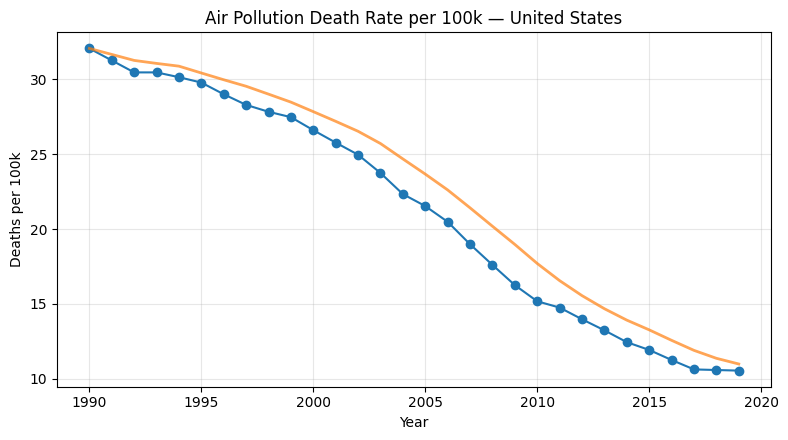

In [9]:
country_of_interest = "United States"  # ← change this
g = df[df["Country"] == country_of_interest].dropna(subset=["Air_Pollution_Deaths_per_100k"]).sort_values("Year")

plt.figure(figsize=(8,4.5))
plt.plot(g["Year"], g["Air_Pollution_Deaths_per_100k"], marker="o")
# optional rolling mean to smooth noise
if len(g) >= 5:
    rolling = g.set_index("Year")["Air_Pollution_Deaths_per_100k"].rolling(5, min_periods=1).mean()
    plt.plot(rolling.index, rolling.values, linewidth=2, alpha=0.7)

plt.title(f"Air Pollution Death Rate per 100k — {country_of_interest}")
plt.xlabel("Year"); plt.ylabel("Deaths per 100k")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


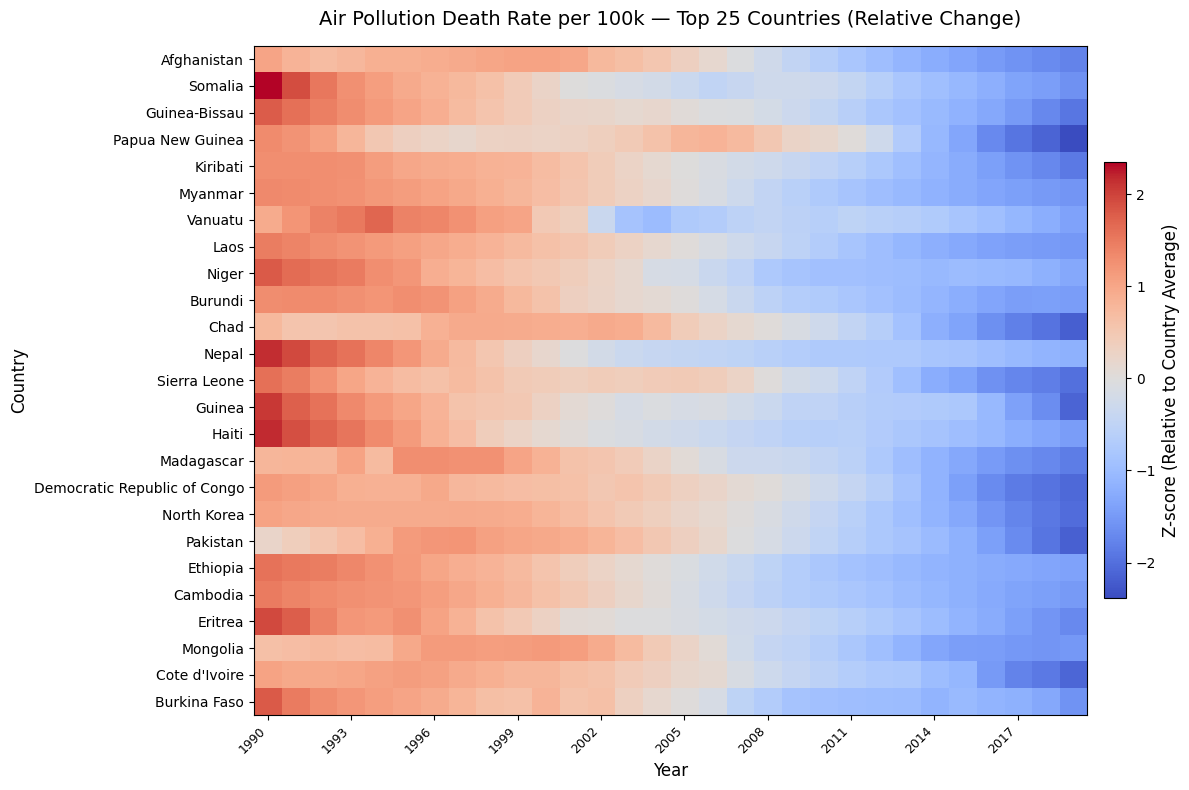

In [15]:
# --- Readable heatmap showing top 25 countries only ---
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Pivot (Country x Year)
pivot = df.pivot_table(
    index="Country",
    columns="Year",
    values="Air_Pollution_Deaths_per_100k",
    aggfunc="mean"
)

# Step 2: Sort by overall average (so you show biggest rates)
top_countries = pivot.mean(axis=1).sort_values(ascending=False).head(25).index
pivot_subset = pivot.loc[top_countries]

# Step 3: Standardize each country (z-score)
z = (pivot_subset - pivot_subset.mean(axis=1, skipna=True).values.reshape(-1,1)) / pivot_subset.std(axis=1, ddof=1, skipna=True).values.reshape(-1,1)

# Step 4: Plot bigger figure with better spacing
plt.figure(figsize=(12, 8))  # smaller height since only 25 countries

im = plt.imshow(z, aspect="auto", interpolation="nearest", cmap="coolwarm")

# Step 5: Add colorbar and labels
cbar = plt.colorbar(im, fraction=0.025, pad=0.02)
cbar.set_label("Z-score (Relative to Country Average)", fontsize=12)

plt.title("Air Pollution Death Rate per 100k — Top 25 Countries (Relative Change)", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Country", fontsize=12)

# Step 6: Tick formatting
plt.xticks(
    ticks=np.arange(len(pivot_subset.columns))[::3],
    labels=pivot_subset.columns[::3],
    rotation=45,
    ha="right",
    fontsize=9
)
plt.yticks(
    ticks=np.arange(len(pivot_subset.index)),
    labels=pivot_subset.index,
    fontsize=10
)

plt.tight_layout()
plt.show()


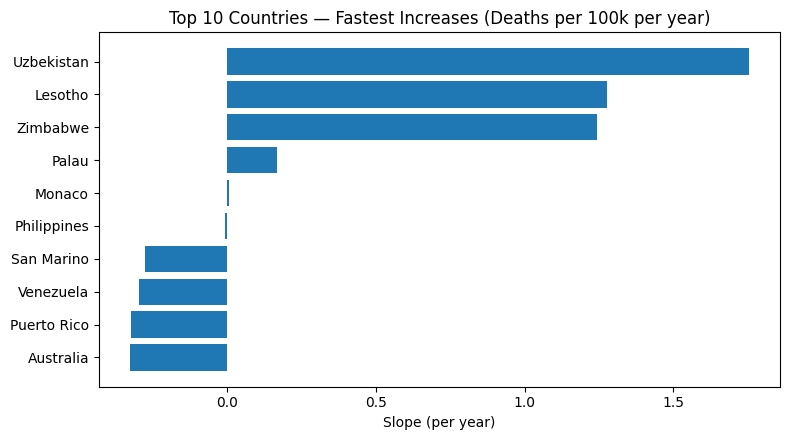

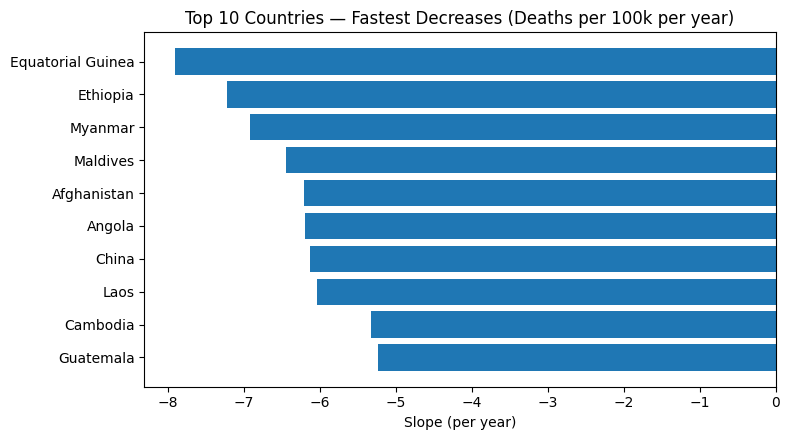

In [11]:
top_up   = trend_table.nlargest(10, "slope_per_year")
top_down = trend_table.nsmallest(10, "slope_per_year")

plt.figure(figsize=(8,4.5))
plt.barh(top_up["Country"], top_up["slope_per_year"])
plt.gca().invert_yaxis()
plt.title("Top 10 Countries — Fastest Increases (Deaths per 100k per year)")
plt.xlabel("Slope (per year)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4.5))
plt.barh(top_down["Country"], top_down["slope_per_year"])
plt.gca().invert_yaxis()
plt.title("Top 10 Countries — Fastest Decreases (Deaths per 100k per year)")
plt.xlabel("Slope (per year)")
plt.tight_layout(); plt.show()


In [12]:
# Limit to rows with all needed columns
avail_drivers = [c for c in drivers_cols if c in df.columns]
core = df.dropna(subset=["Air_Pollution_Deaths_per_100k"] + avail_drivers)

# Compute Pearson correlations across all country-years
corrs = []
for c in avail_drivers:
    r = core["Air_Pollution_Deaths_per_100k"].corr(core[c])
    corrs.append({"driver": c, "pearson_r": r})

drivers_corr = pd.DataFrame(corrs).sort_values("pearson_r", ascending=False)
display(drivers_corr)

# (Optional) per-country correlations to see heterogeneity
country_rows = []
for country, g in core.groupby("Country"):
    if len(g) < 5:
        continue
    for c in avail_drivers:
        r = g["Air_Pollution_Deaths_per_100k"].corr(g[c])
        country_rows.append({"Country": country, "driver": c, "pearson_r": r})
drivers_corr_by_cty = pd.DataFrame(country_rows)
display(drivers_corr_by_cty.groupby("driver")["pearson_r"].mean().sort_values(ascending=False).to_frame("mean_r"))


,driver,pearson_r
0,Deaths_due_to_Household_Air_Pollution,0.202640
1,Deaths_due_to_Smoking,0.015831
2,Deaths_due_to_High_Blood_Pressure,0.010369
4,Deaths_due_to_Alcohol_Use,-0.005801
3,Deaths_due_to_Low_Physical_Activity,-0.062344


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,mean_r
driver,
Deaths_due_to_Household_Air_Pollution,0.742026
Deaths_due_to_Smoking,-0.258573
Deaths_due_to_Alcohol_Use,-0.378161
Deaths_due_to_High_Blood_Pressure,-0.421195
Deaths_due_to_Low_Physical_Activity,-0.643935
